<a href="https://colab.research.google.com/github/rjromo/rubenjromo.com/blob/master/Decision_Trees_drug_py_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se utilizará este algoritmo de clasificación para construir un modelo a partir de datos históricos de pacientes y su respuesta a diferentes medicamentos. Luego, utiliza el árbol de decisión capacitado para predecir la clase de un paciente desconocido o para encontrar un medicamento adecuado para un nuevo paciente.

Importando las librerias
<ul>
    <li> <b>numpy (as np)</b> </li>
    <li> <b>pandas</b> </li>
    <li> <b>DecisionTreeClassifier</b> from <b>sklearn.tree</b> </li>
</ul>

In [0]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

<div id="about_dataset">
    <h2>Sobre el DataSet</h2>
    Imagine que es un investigador médico que recopila datos para un estudio. Ha recopilado datos sobre un conjunto de pacientes, todos los cuales padecían la misma enfermedad. Durante su curso de tratamiento, cada paciente respondió a uno de los 5 medicamentos, Medicamento A, Medicamento B, Medicamento c, Medicamento x e y 
    <br>
    <br>
    El arte de su trabajo es construir un modelo para descubrir qué medicamento podría ser apropiado para un futuro paciente con la misma enfermedad. Los conjuntos de características de este conjunto de datos son la edad, el sexo, la presión arterial y el colesterol de los pacientes, y el objetivo es el medicamento al que respondió cada paciente.
    <br>
    <br>
    Es una muestra de clasificador binario, y puede usar la parte de entrenamiento del conjunto de datos
    para construir un árbol de decisión y luego usarlo para predecir la clase de un paciente desconocido o para prescribirlo a un nuevo paciente.
</div>


<div id="downloading_data"> 
    <h2>Descargando los datos</h2>
    Usaremos !wget para descargarlo desde el IBM Object Storage.
</div>

In [1]:
!wget -O drug200.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/drug200.csv

--2019-10-06 19:15:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/drug200.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6027 (5.9K) [text/csv]
Saving to: ‘drug200.csv’

drug200.csv         100%[===================>]   5.89K  --.-KB/s    in 0s      

2019-10-06 19:15:26 (980 MB/s) - ‘drug200.csv’ saved [6027/6027]



Ahora leeremos usando Pandas DataFrame:

In [4]:
my_data = pd.read_csv("drug200.csv", delimiter=",")
my_data[0:5]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [6]:
my_data.shape

(200, 6)

<div href="pre-processing">
    <h2>Pre-procesando</h2>
</div>

Usando <b>my_data</b> como Drug.csv declaramos las siguientes variables: <br>

<ul>
    <li> <b> X </b> como la <b> Feature Matrix </b> (data of my_data) </li>
    <li> <b> y </b> como el  <b> response vector (target) </b> </li>
</ul>

Elimine la columna que contiene el nombre del objetivo, ya que no contiene valores numéricos.


In [7]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.113999999999999],
       [28, 'F', 'NORMAL', 'HIGH', 7.797999999999999],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

Como puede imaginar, algunas características de este conjunto de datos son categóricas, como __Sex__ o __BP__. Desafortunadamente, los árboles de decisión de Sklearn no manejan variables categóricas. Pero aún podemos convertir estas características en valores numéricos. __pandas.get_dummies () __


In [8]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]


array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.113999999999999],
       [28, 0, 2, 0, 7.797999999999999],
       [61, 0, 1, 0, 18.043]], dtype=object)

Ahora podemos llenar la variable objetivo.

In [13]:
y = my_data["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

<hr>

<div id="setting_up_tree">
    <h2>Configurando el árbol de decisiones</h2>
    Usaremos <b>train/test split</b> en nuestro <b>decision tree</b>. </div>

<b> train_test_split </b> retornará 4 parámetros diferentes. Los nombraremos:<br>
X_trainset, X_testset, y_trainset, y_testset <br> <br>
<b> train_test_split </b> necesitará los parámetros: <br>
X, y, test_size=0.3, y random_state=3. <br> <br>
<b>X</b> y <b>y</b> son los arrays requeridos antes del split, el <b>test_size</b> representa el ratio del testing dataset, y <b>random_state</b> nos asegura que obtenemos los mismos splits.

In [0]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

<hr>

<div id="modeling">
    <h2>Modelando</h2>
    Primero crearemos una instancia del <b>DecisionTreeClassifier</b> llamada <b>drugTree</b>.<br>
    Dentro del clasificador especificaremos <i> criterion="entropy" </i> para que podamos ver la información que gana cada nodo
</div>

In [15]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree # muestra los parámetros por defecto

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Luego, pasamos los datos de la training feature matrix <b> X_trainset </b> y el training  response vector <b> y_trainset </b>

In [16]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

<hr>

<div id="prediction">
    <h2>Predicciones</h2>
    Hagamos algunas <b>predicciones</b> en el testing dataset y guardemos en una variable llamada <b>predTree</b>.
</div>

Imprimamos <b>predTree</b> y <b>y_testset</b> para comparar visualmente los resultados de las predicciones con los valores actuales

In [19]:
predTree = drugTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])


['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
40     drugY
51     drugX
139    drugX
197    drugX
170    drugX
Name: Drug, dtype: object


<hr>

<div id="evaluation">
    <h2>Evaluando</h2>
    Importemos <b>metrics</b> de sklearn y revisemos el accuracy de nuestro modelo
</div>

In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.9833333333333333


<hr>

<div id="visualization">
    <h2>Visualización</h2>
    Veamos nuestro arbol
</div>

In [21]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


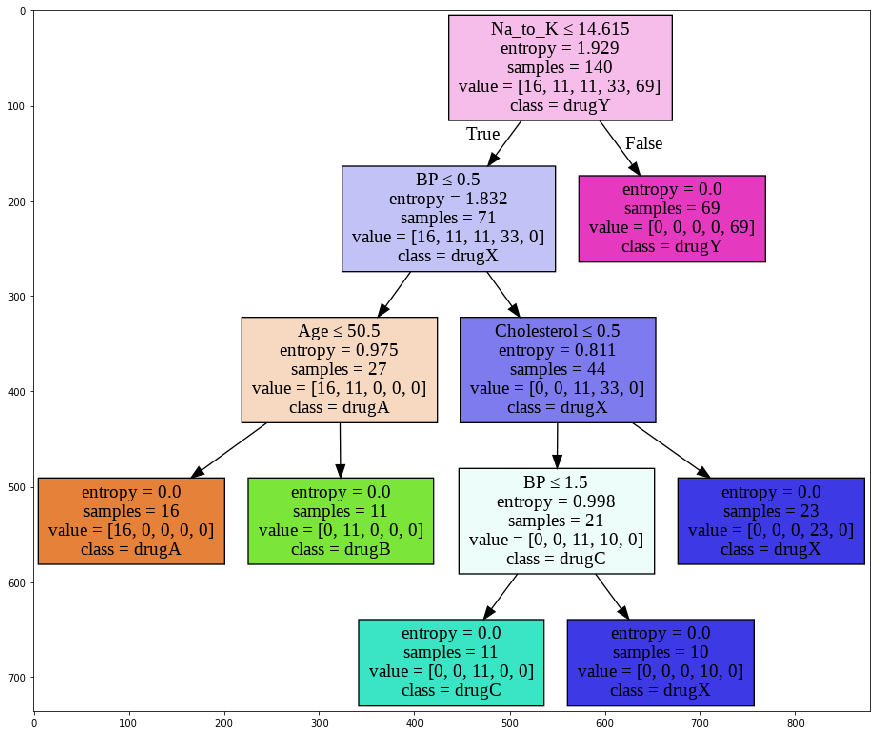

In [25]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = my_data.columns[0:5]
targetNames = my_data["Drug"].unique().tolist()
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(15, 30))
plt.imshow(img,interpolation='nearest')